# Objective: To simplify a pointcloud/mesh while preserving its geometry

In [1]:
# import the required libs
from torch_pdegraph.pdes import pdeisodiff
from torch_pdegraph.utilities import *
import numpy as np
from torch_geometric.nn import knn_graph
import faiss
import torch

In [2]:
#load the pcd/mesh 
(pos, tex, fac) = getPositionTexture("../data/elephant.ply") #specify the required path to data/ folder
#(pos, tex, fac) = getPositionTexture("data/bun_zipper.ply")
params = dict(position=pos, texture=tex, faces=fac)
#displayJSur(**params) #to visualize in notebook or use displaySur to visualize outside the notebook

# Graph construction

- In order to simply show the effectiveness of PDEs on graph,  I am only creating a simple K-NN based graphs. This may or maynot be the best graph for a given problem at hand.

- One can create graph using whatsoever apt approach or one can even use third-party network datasets and run a PDE on that graph.  PDEs are extensible to any given graph/network at hand as long as that graph has edges and weights( edge_index and edge_attr).

Although torch_cluster comes with a knn-graph method. I found it to be limited and  slow when the node-features have high dimensions. We shall be using facebook's faiss library which is blazingly fast for a KNN-graph construction.

In [3]:
# Create a Knn graph of the position coords of the pcd/mesh
# and assign weights to the edges
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(pos.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res,0,index)
gpu_index_flat.add(pos.astype(np.float32))
k = 30
D, I = gpu_index_flat.search(pos.astype(np.float32),k+1)

#Graph 
edge_index = np.vstack((I[:,1:].flatten(), np.repeat(I[:,0].flatten(),k)))
#edge_attr = np.exp(-(D[:,1:].flatten()/np.inf))
edge_attr = np.ones(edge_index.shape[1]) # Let the weights be equal to 1 !
 
edge_index = torch.tensor(edge_index, dtype=torch.long).to('cuda:0')
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to('cuda:0')

edge_attr = edge_attr.view(-1,1)
graph = Graph(edge_index, edge_attr)

# Run a predefined PDE on graph :
We shall be using the following adaptive $dt$  (time step) iterative scheme for **isotropic diffusion**

\begin{equation}
\mathbf{x}^{n+1}_{i} = \frac{\sum_{j \in N(i)} w_{i,j}^{p/2}\|\mathbf{x}^{n}_{j}-\mathbf{x}^{n}_{i}\|_{2}^{p-2}\mathbf{x}^{n}_{j}}{\sum_{j \in N(i)} w_{i,j}^{p/2}\|\mathbf{x}^{n}_{j}-\mathbf{x}^{n}_{i}\|_{2}^{p-2}}
\end{equation}

- $\mathbf{x}_{i}$ is the node feature/signal at the $i^{th}$ node
- $w_{i,j}$ is the scalar edge_attr on the edge $e(i\to j)$


**Example:**
```python
from torch_pdegraph.pdes import pdeisodiff
pde = pdeisodiff.PDE(graph, **hp) # create a pde instance 

# run the pde instance on node features for some iterations
new_features = pde(features, itr) 

"""
graph is a structure which has graph.edge_index and graph.edge_attr(weights)
hp is hyperparams in the equation (p)
"""
```

- To know more ref [Lozes](https://ieeexplore.ieee.org/document/6849979)

In [4]:
#hyperparams
hp = dict(epsilon=5e-10, p_val=0.4) # it was shown to preserve that geometry p < 1

# Run the implicit PDE on graph
features = torch.tensor(pos,dtype=torch.float32).cuda()
itr = 100 #10000

pde = pdeisodiff.PDE(graph, **hp)
new_features = pde(features, itr)

100%|██████████| 100/100 [00:00<00:00, 705.07it/s]


In [5]:
# See the result and compare with the old pcd
displayJSur(**dict(position=new_features.cpu().numpy(), texture=tex))#Or use displaySur for no jupyter visualization

JVisualizer with 1 geometries

In [6]:
displayJSur(**dict(position=pos,texture=tex))#Or use displaySur for no jupyter visualization

JVisualizer with 1 geometries

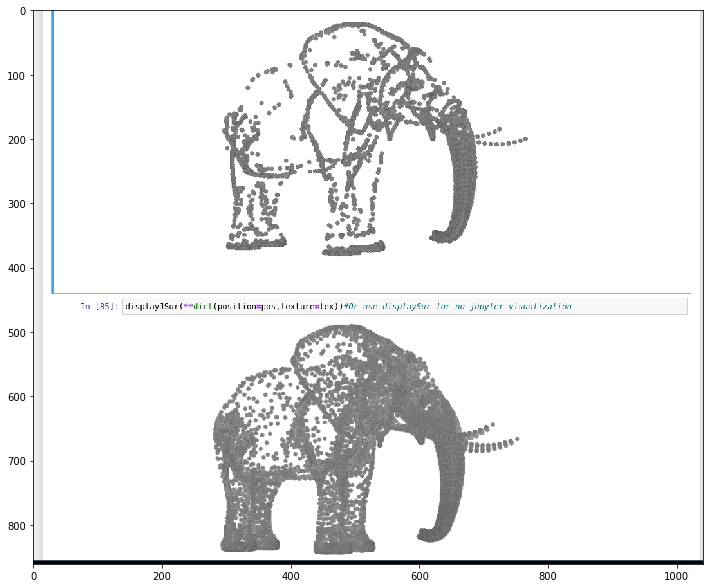

In [10]:
# Unlike an image, a pcd display cannot be saved in ipython notebook, hence the notebook must be running to 
# to view the pcd. Expect to see pcd simplified like shown in the following image.
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
res = mpimg.imread("../gallery/simplification_ele.png")
# res = mpimg.imread("../gallery/simplification_bun.png") #bunny
f = plt.figure(figsize=(12,12))
plt.imshow(res)